[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/4_PINNs.ipynb)

# Physics-Informed Neural Networks (PINNs) in JAX

References:
- Raissi et al.
  [paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125)
- Comparison between PINNs and standard NNs:
  [blog](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)
  post by M. Moseley
- YouTube [video](https://www.youtube.com/watch?v=-zrY7P2dVC4) by R. Brunton
- Medium
  [post](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4)
  by M. Dagrada

A PINN is a **coordinate network** that attempts to approximate the solution to a
partial differential equation $\hat{u}_\theta(t, x) \approx u(t, x)$. The parameters of
the network $\theta^*$ are found by minimizing the following composite loss 
$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta) = \arg\min_\theta \left( \mathcal{L}_\text{PDE}(\theta) + \mathcal{L}_\text{BC}(\theta) \right)
$$
where $\mathcal{L}_\text{PDE}(\theta)$ is the residual of the differential equation
computed at **arbitrary points** and
$\mathcal{L}_\text{BC}(\theta)$ is the residual of the boundary conditions (_training data_). In transient
problems, the residual of the initial conditions is also added to the loss.

Typical architectures for PINNs are Multi-Layer Perceptrons, whose inputs are the
spatial locations $x$ and time $t$ (if applicable). The output of the network is the
solution $\hat{u}_\theta(t, x)$. 

Some key points/limitations:
- The physics (differential equation) is not going to be satisfied exactly (loss is a
  balance between multiple terms)
- The physics-based term makes training harder by altering the loss landscape
- PINNs are effective with small amount of training data (i.e. reconstructing flow
  fields from sparse measurements)
- Fast inference, even though speed of train could be comparable to other methods;
  better generalization than standard (non-physics informed) NNs
- Derivative information is obtained via higher-order automatic
differentiation of the neural network. In particular, to train PINNs to solve PDEs with the highest
derivative order being $k$, we need $k+1$ autodiff passes (i.e. applications of the
`grad` operator in jax).

## Example: 1D Poisson equation

In this simple example we train a PINN in Flax to solve the 1D Poisson equation with homogeneous Dirichlet boundary conditions on the unit interval:
$$
\begin{align}
    \frac{d^2 u}{d x^2} &= - f(x), \quad x \in (0, 1) \\
    u(0) &= u(1) = 0
\end{align}
$$
where the source term is given by
$$
f(x) = \begin{cases}
    1 & \text{if } x > 0.3 \land x < 0.5 \\
    0 & \text{otherwise}
\end{cases}

The terms of the loss function to minimize to train the PINN are given by
$$
\mathcal{L}_\text{PDE}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{d^2
\hat{u}_\theta}{d x^2}\bigg|_{x=x^{[i]}} + f(x^{[i]}) \right)^2
\qquad \text{with} \qquad
x^{[i]} \sim \mathcal{U}(0, 1)
$$
$$
\mathcal{L}_\text{BC}(\theta) = \left( \hat{u}_\theta(0) - 0 \right)^2 + \left( \hat{u}_\theta(1) - 0 \right)^2.
$$
where $x^{[i]}$ are the _collocation points_.

### A reference solution by Finite Differences

To check whether the network is able to learn an accurate solution to the PDE, we
compare the solution with that obtained by Finite Differences.

1. Discretize the unit interval into $M+2$ _uniformly spaced_ points, such that $\Delta
   x = 1/(M+1)$.
2. Solve the linear system of equations $A u = b$ with $A \in \mathbb{R}^{M \times M}$ and $b \in \mathbb{R}^N$ with
    1. $A$ corresponds to the second order _centered_ approximation for the second derivative (tri-diagonal matrix with $1$ on the off-diagonals and $-2$ on the diagonal, scaled by $\frac{1}{(\Delta x)^2}$)
    2. $b$ is the right-hand side of the PDE evaluated at the interior points, i.e., $b_i = - f(x_i)$
3. Append (pre/post) the boundary conditions to the solution vector $u$ and plot the solution.

In [3]:
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
from flax import nnx
import optax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # progress bar
import logging

In [4]:
num_interior_nodes = 99
dx = 1/(num_interior_nodes+1)
BC_LOSS_WEIGHT = 100.0

In [5]:
mesh_full = jnp.linspace(0.0, 1.0, num_interior_nodes + 2)
mesh_interior = mesh_full[1:-1]

In [6]:
rhs_function = lambda x: jnp.where((x > 0.3) & (x < 0.5), 1.0, 0.0)
rhs_evaluated = rhs_function(mesh_interior)

In [7]:
# Finite Differences solution
A = jnp.diag(jnp.ones(num_interior_nodes - 1), -1) + jnp.diag(jnp.ones(num_interior_nodes - 1), 1) - jnp.diag(2 * jnp.ones(num_interior_nodes), 0)
A /= dx**2
finite_difference_solution = jnp.linalg.solve(A, -rhs_evaluated)

In [8]:
# Adding boundary conditions
wrap_bc = lambda u: jnp.pad(u, (1, 1), mode="constant")

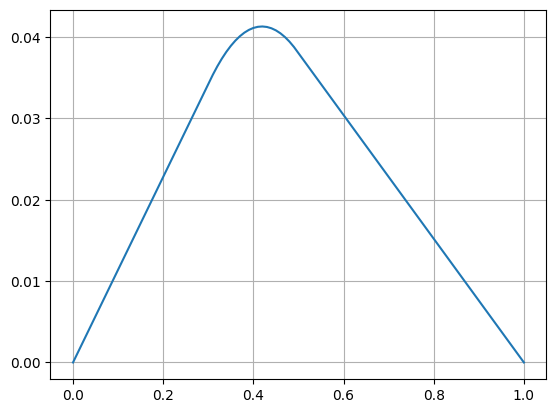

In [9]:
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.grid()
plt.show()

### PINN solution

In [10]:
# PINN architecture
class Model(nnx.Module):
  def __init__(self, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(1, 10, rngs=rngs)
    self.linear2 = nnx.Linear(10, 10, rngs=rngs)
    self.linear3 = nnx.Linear(10, 10, rngs=rngs)
    self.linear4 = nnx.Linear(10, 1, rngs=rngs)

  # IMPORTANT: define the forward pass to operate on a single scalar (shape (1,)) and
  # return a scalar for jax.grad to work (we will vectorize over samples using vmap)
  def __call__(self, x):
    y = self.linear1(x)
    y = nnx.sigmoid(y) # choose a differentiable activation
    y = self.linear2(y)
    y = nnx.sigmoid(y)
    y = self.linear3(y)
    y = nnx.sigmoid(y)
    y = self.linear4(y)
    return y.squeeze() # shape = (1,) -> shape = ()

In [11]:
# PDE residual computed on a single sample (shape = (1,))
def pde_residual(model, x):
    grad_x = lambda x: jax.grad(model)(x).squeeze() # shape = (1,) -> shape = (), because grad only works with functions that return scalars
    return jax.grad(grad_x)(x) + rhs_function(x)

In [12]:
# Physics-informed loss
@nnx.jit
def loss_fn(model, x):
    pde_residual_at_collocation_points = jax.vmap(pde_residual, in_axes=(None, 0))(model, x)
    pde_loss_contribution = jnp.mean(jnp.square(pde_residual_at_collocation_points))

    left_bc_residual = model(jnp.array([0.0])) - 0.0
    right_bc_residual = model(jnp.array([1.0])) - 0.0
    bc_residual_contribution = jnp.mean(jnp.square(left_bc_residual)) + jnp.mean(jnp.square(right_bc_residual))

    total_loss = pde_loss_contribution + BC_LOSS_WEIGHT * bc_residual_contribution

    return total_loss

#### Auxiliary functions

In [13]:
@nnx.jit
def train_step(model, optimizer, x):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x)
    optimizer.update(grads)
    return loss

def _train_epoch(
    model, optimizer, xs_train, batch_size, rng
):
    train_ds_size = len(xs_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, len(xs_train))
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_xs = xs_train[perm]
        loss = train_step(model, optimizer, batch_xs)
        epoch_loss.append(loss)  # store training loss for the current batch

    train_loss = np.mean(epoch_loss)
    return model, train_loss


def train(model, optimizer, xs_train, 
          batch_size,epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1)): # disable=not show_progress
        model, train_loss = _train_epoch(
            model, optimizer, xs_train, 
            batch_size, random.key(1),
        )

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

In [14]:
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score

In [15]:
class MLPRegressor(BaseEstimator):

    def __init__(self, model, lr, epochs, batch_size, log_period_epoch=10, show_progress=True):
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_period_epoch = log_period_epoch
        self.show_progress = show_progress

    def fit(self, X, y=None):
        self._optimizer = nnx.Optimizer(self.model, optax.adam(self.lr))

        self.train_loss_history = train(self.model, self._optimizer, X, self.batch_size, self.epochs, self.log_period_epoch, self.show_progress)

        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        return jax.vmap(self.model)(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)    

In [16]:
lr = 1e-3
epochs = 10_000
num_collocation_points = 50

# Create model and wrap into the MLPRegressor (to use sklearn APIs)
pinn = Model(rngs=nnx.Rngs(0))
m = MLPRegressor(pinn, lr, epochs, num_collocation_points)

In [17]:
key = random.key(42)
collocation_points = random.uniform(key, (num_collocation_points, 1), minval=0.0 + 0.001, maxval=1.0 - 0.001)

m.fit(collocation_points)

  0%|          | 0/10000 [00:00<?, ?it/s]

MLPRegressor(batch_size=50, epochs=10000, lr=0.001,
             model=Model(
  linear1=Linear(
    bias=Param(
      value=Array(shape=(10,), dtype=float32)
    ),
    bias_init=<function zeros at 0x0000018D1EC20A40>,
    dot_general=<function dot_general at 0x0000018D1D7742C0>,
    dtype=None,
    in_features=1,
    kernel=Param(
      value=Array(shape=(1, 10), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<local...
      value=Array([0.01990789], dtype=float32)
    ),
    bias_init=<function zeros at 0x0000018D1EC20A40>,
    dot_general=<function dot_general at 0x0000018D1D7742C0>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x0000018D1EDC9760>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
))

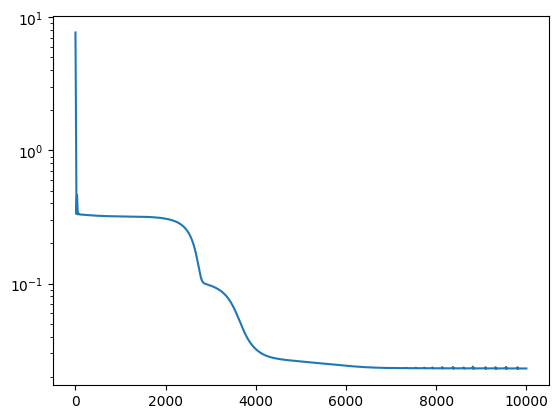

In [18]:
plt.plot(m.train_loss_history)
plt.yscale("log")

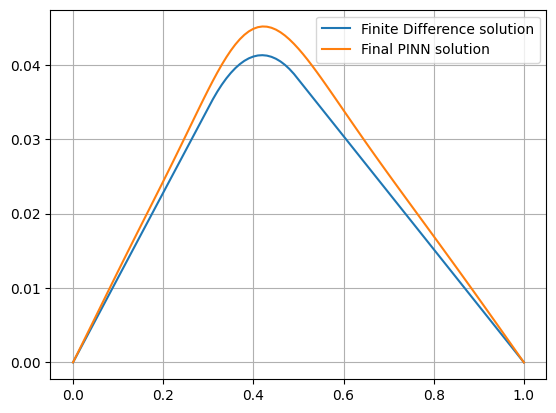

In [19]:
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.plot(mesh_full, pinn(mesh_full.reshape(-1,1)), label="Final PINN solution")
plt.legend()
plt.grid()

In [20]:
m.score(mesh_full.reshape(-1,1), wrap_bc(finite_difference_solution))

0.9632484912872314

## Exercise: Burgers' equation

We consider the following viscous Burgers equation:
\begin{align}
  &u_t + uu_x -\nu u_{xx} = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}
where $\nu$ is the PDE parameter. In this section, we take $\nu=0.025$.

The loss function, which includes the loss the IC/BC and the PDE residuals, now reads:
\begin{align}
  \mathcal{L} &= \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{IC}} + \mathcal{L}_{\text{BC}}\\
    &= \dfrac{1}{N_{pde}}\sum_{i=1}^{N_{pde}}[\hat{u}_{t}(x^i, t^i) + \hat{u}\hat{u}_{x}(x^i, t^i)-\nu \hat{u}_{xx}(x^i, t^i)]^2 + \dfrac{1}{N_{ic}}\sum_{i=1}^{N_{ic}}(\hat{u}(x^i,0) + \sin(\pi x^i))^2 + \dfrac{1}{N_{bc}}\sum_{i=1}^{N_{bc}}(\hat{u}(-1,t^i)^2+\hat{u}(1,t^i)^2).
\end{align}

We take the following steps to build a PINN model:
1. Define the domain
2. Define the initial/boundary conditions (IC/BC) and the training points
3. Define PDE residuals and loss term for the PDE
4. Define PINNs architecture
5. Training

In [21]:
# Discretization of the domain (mesh)
nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Viscosity
nu = 0.025

- Define the IC/BC and training points

In [3]:
# For boundary and initial conditions define the matrices of the (x,t) points
# corresponding to the boundaries where BCs or initial conditions are prescribe and the
# corresponding values (u_bc and u_init) of the solution.
# X_init = ...
# u_init = ...
# X_bc = ...
# u_bc = ...

num_collocation_points = 2000
# Collocation points: matrix of randomly chosen (x,t) pairs from the X_star matrix 
# X_colloc_train = ... 

In [4]:
#@title Solution:

# Define the IC
idx_init = np.where(X_star[:, 1]==0)[0]
X_init = X_star[idx_init]
u_init = -np.sin(np.pi*X_init[:, 0:1])

# Define the BC
idx_bc = np.where((X_star[:, 0]==1.0)|(X_star[:, 0]==-1.0))[0]
X_bc = X_star[idx_bc]
u_bc = np.zeros((X_bc.shape[0], 1))

# Define training collocation points
idx_Xf = np.random.choice(X_star.shape[0], num_collocation_points, replace=False)
X_colloc_train = X_star[idx_Xf]

In [ ]:
# Plot of the training (supervised) and the collocation (non-supervised) points
X_supervised = np.concatenate((X_init, X_bc), axis=0)
u_supervised = np.concatenate((u_init, u_bc), axis=0)

fig = plt.figure(figsize=[7,3])
axes = fig.subplots(1,2, sharex=False, sharey=False)
img1 = axes[0].scatter(X_supervised[:, 0:1], X_supervised[:, 1:2], c=u_supervised, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Supervised points', fontsize=10)
axes[0].set_xlabel('x', fontsize=10)
axes[0].set_ylabel('t', fontsize=10)
img2 = axes[1].plot(X_colloc_train[:, 0], X_colloc_train[:, 1], 'x', markersize=5, color='black')
axes[1].set_title('Collocation/Non-supervised points', fontsize=10)
axes[1].set_xlabel('x', fontsize=10)
axes[1].set_ylabel('t', fontsize=10)
plt.show()

- Define the model

In [124]:
class Model(nnx.Module):
  def __init__(self, rngs: nnx.Rngs):
    # Define linear layers here (notice the number of input/output features)
    # self.linear1 = nnx.Linear(2, ..., rngs=rngs)
    # self.linear2 = nnx.Linear(..., 1, rngs=rngs)
    pass

  def __call__(self, x):
    # Define the forward pass for a single sample, i.e. (x,t) pair stored in an array 
    # with shape (2,)
    # return y.squeeze()
    pass

In [6]:
#@title Solution:

class Model(nnx.Module):
  def __init__(self, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(2, 20, rngs=rngs)
    self.linear2 = nnx.Linear(20, 20, rngs=rngs)
    self.linear3 = nnx.Linear(20, 20, rngs=rngs)
    self.linear4 = nnx.Linear(20, 1, rngs=rngs)

  def __call__(self, x):
    y = self.linear1(x)
    y = nnx.tanh(y)
    y = self.linear2(y)
    y = nnx.tanh(y)
    y = self.linear3(y)
    y = nnx.tanh(y)
    y = self.linear4(y)
    return y.squeeze()

- Implement the calculation of the PDE residual

In [119]:
def pde_residual(model, x):
    pass

In [7]:
#@title Solution:

def pde_residual(model, x):
    grad_x = lambda x: jax.grad(model)(x)[0]
    grad_t = lambda x: jax.grad(model)(x)[1]
    u_x = grad_x(x)
    u_t = grad_t(x)
    u_xx = jax.grad(grad_x)(x)[0]
    u = model(x)
    f = u_t + u*u_x - nu*u_xx

    return f

- Define the loss function

In [121]:
@nnx.jit
def loss_fn(model, x):
    pass

In [8]:
#@title Solution:

@nnx.jit
def loss_fn(model, x):
    pde_residual_at_collocation_points = jax.vmap(pde_residual, in_axes=(None, 0))(model, x)
    pde_loss_contribution = jnp.mean(jnp.square(pde_residual_at_collocation_points))

    bc_residual = model(X_bc)
    bc_residual_contribution = jnp.mean(jnp.square(bc_residual))

    init_residual = model(X_init) + jnp.sin(jnp.pi*X_init[:,0])
    init_residual_contribution = jnp.mean(jnp.square(init_residual))

    total_loss = pde_loss_contribution + bc_residual_contribution + init_residual_contribution

    return total_loss

- Create an instance of the PINN and wrap into the `MLPRegressor` class. Train the
  model. NOTE: if you experience issues, you may need to restart the kernel and/or re-evaluate the cells above where the training functions are defined,
  befor running the training.

In [ ]:
# ...
# m = MLPRegressor(...)
# ...

In [ ]:
#@title Solution:

pinn = Model(nnx.Rngs(0))
m = MLPRegressor(pinn, 0.001, 5000, 64)
m.fit(X_colloc_train)

- Plot the training curve (history of the training loss)

In [ ]:
plt.plot(m.train_loss_history)
plt.yscale("log")

- Compare the prediction of the trained PINN over all the mesh `X_star` with the
  reference solution.

In [18]:
# Load reference solution
u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[-1]

# Compute PINN prediction
# pred = ...

In [19]:
#@title Solution:

pred = m.predict(X_star)

In [ ]:
# Plot and compare the solutions
fig = plt.figure(figsize=[15,3])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINN prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred[:,None], cmap='seismic', vmax=0.01, vmin=-0.01, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])
plt.show()

- Evaluate the R^2 score between the predictions and the reference solution

In [21]:
# ...

In [ ]:
#@title Solution:

m.score(X_star, u_star.ravel())